# Positional Encoding Define

In [ ]:
# 해당 과정을 한번에 처리할 수 있는 함수
def mk_encoder_input(input, n_seq = 128, hiddin_size = 512):
  def encoding_input(input):
    inputs_encoded = []
    for raw in input:
      encoded = tokenizer.encode(raw)
      inputs_encoded.append(torch.tensor(encoded))
    inputs_pad = torch.nn.utils.rnn.pad_sequence(inputs_encoded, batch_first=True, padding_value = 0)
    return inputs_pad

  def embedding_input(inputs_encoded):
    n_vocab = tokenizer.vocab_size #30000 
    hidden_size = 512
    nn_emb = nn.Embedding(n_vocab, hidden_size)
    embeded_inputs = nn_emb(inputs_pad)
    
    return embeded_inputs

  #ex) position이 0일때, i : 0~512까지의 pos/(10000 ** (2i/d_model))을 계산해준다.
  def calculation(position, i):
    return position / (10000 ** ((2*(i//2))/hiddin_size))

  def postion_angle_vector(position):
      return [calculation(position, i) for i in range(hiddin_size)]

  encoded = encoding_input(input)
  embedded = embedding_input(encoded)

  position = torch.arange(embedded.size(1)).expand(embedded.size(0), embedded.size(1))
  positional_encoding = np.array([postion_angle_vector(pos) for pos in range(n_seq)])
  positional_encoding[:, 0::2] = np.sin(positional_encoding[:, 0::2])
  positional_encoding[:, 1::2] = np.cos(positional_encoding[:, 1::2])

  pos_encoding = torch.FloatTensor(positional_encoding)
  pos_embedding = nn.Embedding.from_pretrained(pos_encoding, freeze = True)
  pos_enc = pos_embedding(position)

  # inputs_encoded는 attention mask를 만들기 위해 사용된다.
  return inputs_pad, embedded + pos_enc

In [ ]:
# Embedding은 초기에는 임의의 값을 가지고 훈련이 지속되면서 업데이트 되므로, 해당 함수는 실행할 때 마다 결과가 다르다.
mk_encoder_input(['어제 카페 갔었어 거기 사람 많더라', '날이 추우니 감기 조심하세요'])

(tensor([[    2,  9909, 14786,   212, 11320,  8788,  7978, 28026,     3],
         [    2, 12283,  2933, 16626, 18468, 26874,     3,     0,     0]]),
 tensor([[[ 5.2249e-01,  2.4457e+00, -5.5455e-01,  ...,  3.1429e+00,
            1.6904e+00,  1.0134e+00],
          [-4.7217e-01,  3.8983e-01,  1.1183e+00,  ...,  3.1506e+00,
            1.9815e-01,  1.6348e-01],
          [-8.5531e-01, -3.2104e-01,  1.4364e+00,  ..., -9.4942e-01,
           -1.1474e+00,  2.9921e+00],
          ...,
          [-5.2346e-02, -1.2233e+00, -7.8969e-01,  ...,  8.1560e-02,
            5.4286e-01,  2.2006e+00],
          [ 3.0088e+00,  1.0414e+00,  4.2388e-01,  ...,  1.3594e+00,
           -4.9535e-01,  1.1524e+00],
          [ 1.9173e+00, -1.4202e+00, -2.2984e-01,  ...,  9.6196e-01,
            1.8959e-01,  1.8784e+00]],
 
         [[ 5.2249e-01,  2.4457e+00, -5.5455e-01,  ...,  3.1429e+00,
            1.6904e+00,  1.0134e+00],
          [ 8.0578e-01, -8.3114e-01,  7.3612e-01,  ...,  4.2523e-01,
           -1.

# Scaled Dot-Production Attention

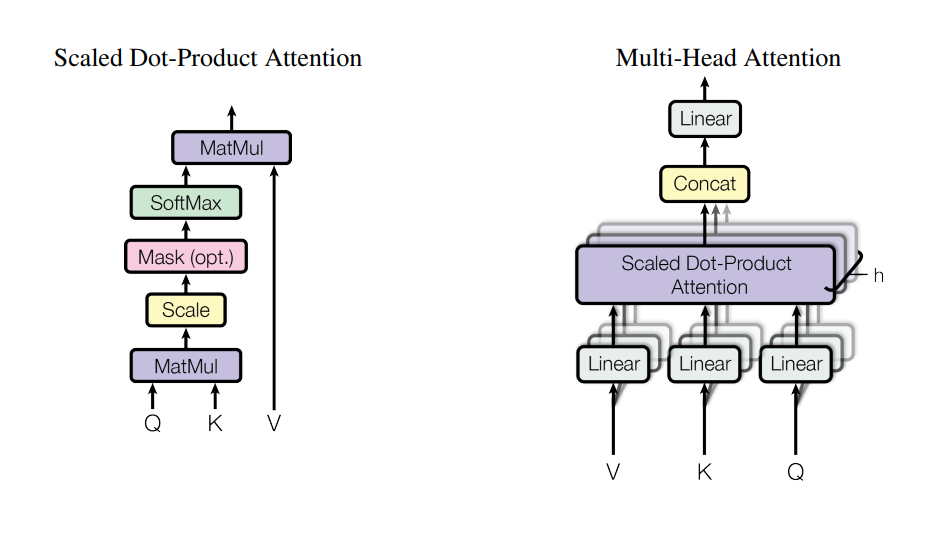

* Scaled Dot-Product Attention : 단어 벡터끼리의 내적(Dot-Product) 후 scale을 거쳐 벡터의 유사도를 구하는 과정, Softmax 함수를 통과하여 유사도를 확률로 바꿔준다.
* Self-Attention(Encoder) : 똑같은 문장에서 세개의 벡터를 만들어서 문장 내 token과 다른 token의 관계(attention score)를 파악하기 위해서 적용
* 동일한 encode input에서 각기 다른 가중치를 곱하여 Q, K, V를 만드는 과정(인데 현재는 Linear 과정을 제거)

In [ ]:
input_encoded, encoder_input = mk_encoder_input(['어제 카페 갔었어 거기 사람 많더라', '날이 추우니 감기 조심하세요'])

In [ ]:
# Query, Key 등이 같다는 것은 벡터의 값이 같다는 것이 아니라 벡터의 출처가 같다.
input_encoded, encoder_input = mk_encoder_input(['어제 카페 갔었어 거기 사람 많더라', '날이 추우니 감기 조심하세요'])
for v in ['Q', 'K', 'V']:
  globals()["{}".format(v)] = encoder_input

In [ ]:
print(Q, Q.size(), K, K.size(), V, V.size())

tensor([[[-0.8669, -0.1337, -2.0665,  ...,  0.5032, -1.7731, -0.8362],
         [ 0.3574,  1.8314,  1.7790,  ..., -0.7684, -0.5150,  1.5020],
         [-0.9422,  0.4982,  1.3313,  ...,  1.9334,  1.4762,  1.3210],
         ...,
         [-0.2106,  1.4776, -1.0045,  ...,  1.7191, -0.7575, -0.2289],
         [ 3.0131,  1.1333, -0.7151,  ...,  1.8727,  0.2829,  1.4821],
         [ 1.9239,  1.3763,  1.9829,  ...,  1.9681,  0.8506, -0.3942]],

        [[-0.8669, -0.1337, -2.0665,  ...,  0.5032, -1.7731, -0.8362],
         [ 1.4858,  0.1221,  0.1632,  ...,  2.3712, -1.2020,  1.5029],
         [ 1.6512,  0.1302,  1.5423,  ...,  1.1751,  0.9526, -0.2480],
         ...,
         [ 0.6551,  2.4820,  0.5170,  ...,  1.9681,  0.8504, -0.3942],
         [ 2.0715, -0.7074, -0.6400,  ..., -0.2844,  0.1227,  0.4160],
         [ 2.4039, -1.6068, -0.1017,  ..., -0.2844,  0.1228,  0.4160]]],
       grad_fn=<AddBackward0>) torch.Size([2, 9, 512]) tensor([[[-0.8669, -0.1337, -2.0665,  ...,  0.5032, -1.7731, 

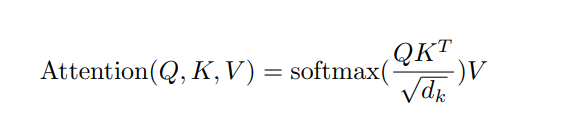

In [ ]:
# Q X Kt
# 둘다 동일한 2, 9, 512 크기의 행렬이므로 곱하려면 2, 9, 512 / 2, 512, 9가 되어야 한다. (전치행렬)
score = torch.matmul(Q, K.transpose(2, 1))
print(score[0], score.size())

tensor([[656.2495, 229.6519, 185.9480, 167.3975, 166.6611, 146.4021, 149.7499,
         157.4277, 159.9090],
        [229.6519, 837.3824, 306.0613, 286.2606, 247.7160, 199.0836, 189.5826,
         237.5940, 175.3871],
        [185.9480, 306.0613, 743.2764, 255.4283, 233.3521, 223.1953, 248.2462,
         216.0337, 213.2090],
        [167.3975, 286.2606, 255.4283, 778.8284, 264.2921, 256.0493, 212.2599,
         194.8099, 169.9258],
        [166.6611, 247.7160, 233.3521, 264.2921, 772.4841, 285.1342, 229.7202,
         265.4020, 183.6370],
        [146.4021, 199.0836, 223.1953, 256.0493, 285.1342, 815.7159, 258.9089,
         263.9771, 215.3347],
        [149.7499, 189.5825, 248.2462, 212.2599, 229.7202, 258.9089, 718.4081,
         255.3198, 220.9257],
        [157.4277, 237.5939, 216.0337, 194.8099, 265.4019, 263.9772, 255.3198,
         825.9730, 246.9935],
        [159.9090, 175.3870, 213.2089, 169.9258, 183.6370, 215.3349, 220.9257,
         246.9935, 787.8851]], grad_fn=<SelectBac

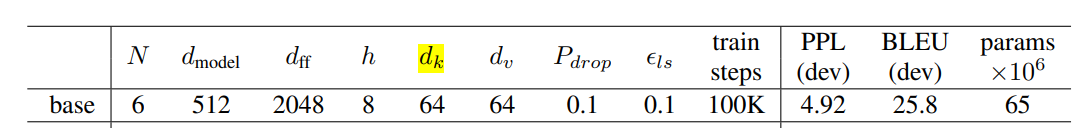

In [ ]:
# base 모델의 dk = d_model/h = 64
score = score/ (64 ** 0.5)
print(score[0], score.size())

tensor([[ 82.0312,  28.7065,  23.2435,  20.9247,  20.8326,  18.3003,  18.7187,
          19.6785,  19.9886],
        [ 28.7065, 104.6728,  38.2577,  35.7826,  30.9645,  24.8855,  23.6978,
          29.6992,  21.9234],
        [ 23.2435,  38.2577,  92.9095,  31.9285,  29.1690,  27.8994,  31.0308,
          27.0042,  26.6511],
        [ 20.9247,  35.7826,  31.9285,  97.3535,  33.0365,  32.0062,  26.5325,
          24.3512,  21.2407],
        [ 20.8326,  30.9645,  29.1690,  33.0365,  96.5605,  35.6418,  28.7150,
          33.1752,  22.9546],
        [ 18.3003,  24.8855,  27.8994,  32.0062,  35.6418, 101.9645,  32.3636,
          32.9971,  26.9168],
        [ 18.7187,  23.6978,  31.0308,  26.5325,  28.7150,  32.3636,  89.8010,
          31.9150,  27.6157],
        [ 19.6785,  29.6992,  27.0042,  24.3512,  33.1752,  32.9971,  31.9150,
         103.2466,  30.8742],
        [ 19.9886,  21.9234,  26.6511,  21.2407,  22.9546,  26.9169,  27.6157,
          30.8742,  98.4856]], grad_fn=<SelectBac

In [ ]:
# input_encoded :
# [2, 9909, 14786, 212, 11320, 8788, 7978, 28026, 3],
# [2, 12283, 2933, 16626, 18468, 26874, 3, 0, 0]]
# pad token [pad] 해당하는 0의 위치를 찾는다.
attention_mask = input_encoded.eq(0).unsqueeze(1).expand(Q.size(0), Q.size(1), Q.size(1))
print(attention_mask, attention_mask.size())

tensor([[[False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False]],

        [[False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False, False, False, False,  True,  True],
         [False, False, False, False

In [ ]:
# 두번째 문장의 마지막 끝에 2개의 attention score가 0 처리가 되었다. 
# mask : [pad] token의 값을 0으로 만든다. True 부분이 0으로 되어있는 pad token
score.masked_fill(attention_mask, 0)

tensor([[[ 82.0312,  28.7065,  23.2435,  20.9247,  20.8326,  18.3003,  18.7187,
           19.6785,  19.9886],
         [ 28.7065, 104.6728,  38.2577,  35.7826,  30.9645,  24.8855,  23.6978,
           29.6992,  21.9234],
         [ 23.2435,  38.2577,  92.9095,  31.9285,  29.1690,  27.8994,  31.0308,
           27.0042,  26.6511],
         [ 20.9247,  35.7826,  31.9285,  97.3535,  33.0365,  32.0062,  26.5325,
           24.3512,  21.2407],
         [ 20.8326,  30.9645,  29.1690,  33.0365,  96.5605,  35.6418,  28.7150,
           33.1752,  22.9546],
         [ 18.3003,  24.8855,  27.8994,  32.0062,  35.6418, 101.9645,  32.3636,
           32.9971,  26.9168],
         [ 18.7187,  23.6978,  31.0308,  26.5325,  28.7150,  32.3636,  89.8010,
           31.9150,  27.6157],
         [ 19.6785,  29.6992,  27.0042,  24.3512,  33.1752,  32.9971,  31.9150,
          103.2466,  30.8742],
         [ 19.9886,  21.9234,  26.6511,  21.2407,  22.9546,  26.9169,  27.6157,
           30.8742,  98.4856]],


In [ ]:
sf_score = nn.Softmax(dim=-1)(score)

In [ ]:
# Softmax 함수를 통과시켜 각 token별 관계를 나타내는 score를 확률로 변환시켜 준다.
# 원래는 서로 다른 가중치를 곱해야 하지만, 단어 사이의 대략적인 관계를 보고 위해 모두 같은 벡터를 사용
# 대각선(자기 자신과의 연관이 있을 확률이 100%로 나타난다)
# 학습이 진행되면서 update
print(sf_score[0], sf_score.size())

tensor([[1.0000e+00, 6.9403e-24, 2.9433e-26, 2.8959e-27, 2.6412e-27, 2.0990e-28,
         3.1897e-28, 8.3284e-28, 1.1357e-27],
        [1.0192e-33, 1.0000e+00, 1.4331e-29, 1.2060e-30, 9.7474e-33, 2.2325e-35,
         6.8078e-36, 2.7504e-33, 1.1545e-36],
        [5.5516e-31, 1.8407e-24, 1.0000e+00, 3.2831e-27, 2.0789e-28, 5.8406e-29,
         1.3378e-27, 2.3860e-29, 1.6762e-29],
        [6.4175e-34, 1.8200e-27, 3.8573e-29, 1.0000e+00, 1.1681e-28, 4.1686e-29,
         1.7491e-31, 1.9747e-32, 8.8028e-34],
        [1.2936e-33, 3.2510e-29, 5.3981e-30, 2.5815e-28, 1.0000e+00, 3.4940e-27,
         3.4283e-30, 2.9657e-28, 1.0799e-32],
        [4.6248e-37, 3.3497e-34, 6.8225e-33, 4.1447e-31, 1.5718e-29, 1.0000e+00,
         5.9255e-31, 1.1165e-30, 2.5540e-33],
        [1.3470e-31, 1.9577e-29, 2.9951e-26, 3.3330e-28, 2.9559e-27, 1.1357e-25,
         1.0000e+00, 7.2513e-26, 9.8461e-28],
        [5.0911e-37, 1.1449e-32, 7.7328e-34, 5.4471e-35, 3.7016e-31, 3.0977e-31,
         1.0497e-31, 1.0000e+0

In [ ]:
V.size()

torch.Size([2, 9, 512])

In [ ]:
V

tensor([[[-0.8669, -0.1337, -2.0665,  ...,  0.5032, -1.7731, -0.8362],
         [ 0.3574,  1.8314,  1.7790,  ..., -0.7684, -0.5150,  1.5020],
         [-0.9422,  0.4982,  1.3313,  ...,  1.9334,  1.4762,  1.3210],
         ...,
         [-0.2106,  1.4776, -1.0045,  ...,  1.7191, -0.7575, -0.2289],
         [ 3.0131,  1.1333, -0.7151,  ...,  1.8727,  0.2829,  1.4821],
         [ 1.9239,  1.3763,  1.9829,  ...,  1.9681,  0.8506, -0.3942]],

        [[-0.8669, -0.1337, -2.0665,  ...,  0.5032, -1.7731, -0.8362],
         [ 1.4858,  0.1221,  0.1632,  ...,  2.3712, -1.2020,  1.5029],
         [ 1.6512,  0.1302,  1.5423,  ...,  1.1751,  0.9526, -0.2480],
         ...,
         [ 0.6551,  2.4820,  0.5170,  ...,  1.9681,  0.8504, -0.3942],
         [ 2.0715, -0.7074, -0.6400,  ..., -0.2844,  0.1227,  0.4160],
         [ 2.4039, -1.6068, -0.1017,  ..., -0.2844,  0.1228,  0.4160]]],
       grad_fn=<AddBackward0>)

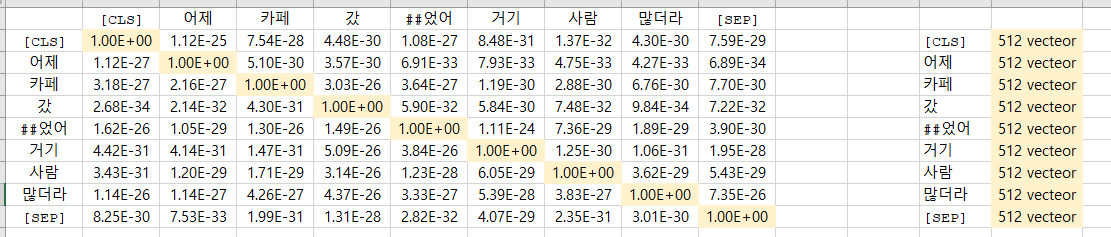

In [ ]:
# 다시 V 와 matmul
# 각 token과 token이 연관성의 확률을 문장 내 모든 토큰의 vector와 곱한 가중합을 만든다.
# 첫번째 token이 나머지 token과 가지는 연관 확률을 문장내 token의 모든 벡터와 곱한 가중합
context = torch.matmul(score, V)

In [ ]:
print(context[0], context.size())

tensor([[   1.8110,  160.4419, -126.8424,  ...,  194.8853, -179.0293,
           64.9351],
        [  94.9933,  346.5579,  109.3514,  ...,  178.7368, -137.0937,
          274.5062],
        [  20.6341,  271.4067,   79.2634,  ...,  348.2598,   -9.8968,
          246.6682],
        ...,
        [  75.1300,  314.8511,  -83.1503,  ...,  351.0991, -122.0518,
          145.7021],
        [ 306.7381,  325.1228,  -72.5257,  ...,  387.6856,  -64.0709,
          269.6788],
        [ 227.0383,  304.9111,  122.0206,  ...,  368.8785,   -6.3058,
          108.6429]], grad_fn=<SelectBackward0>) torch.Size([2, 9, 512])


# Scaled Dot-Product Attention Define

In [ ]:
input_encoded, encoder_input = mk_encoder_input(['어제 카페 갔었어 거기 사람 많더라', '날이 추우니 감기 조심하세요'])

In [ ]:
encoder_input

tensor([[[-0.0665,  1.5674,  1.0261,  ...,  1.9411, -1.1338,  0.1734],
         [ 1.8296,  1.0942,  0.9816,  ...,  2.3815,  0.4888,  0.8316],
         [ 0.5001, -0.9563, -0.0600,  ...,  1.0068,  1.4057,  3.2197],
         ...,
         [-0.1000,  1.8567,  0.6869,  ...,  0.4535,  0.4911, -0.4215],
         [ 1.2043,  0.5181,  0.9267,  ...,  0.6268, -0.2701,  2.0777],
         [ 1.7280, -1.0679,  1.1421,  ..., -0.1547,  0.3306,  2.4523]],

        [[-0.0665,  1.5674,  1.0261,  ...,  1.9411, -1.1338,  0.1734],
         [ 0.4505, -0.5599, -0.9508,  ...,  0.3702,  2.1363,  0.7487],
         [-0.1976,  1.6575,  2.6906,  ...,  1.5206,  0.8944,  0.7642],
         ...,
         [ 0.4592,  0.0377, -0.3238,  ..., -0.1547,  0.3304,  2.4523],
         [ 0.7420,  1.0735,  1.6675,  ...,  2.1467,  0.8628, -0.2777],
         [ 1.0744,  0.1741,  2.2058,  ...,  2.1467,  0.8629, -0.2777]]],
       grad_fn=<AddBackward0>)

In [ ]:
class SDPAD(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, Q, K, V, attention_mask):
    score = torch.matmul(Q, K.transpose(-1, -2))
    score = score / (64 ** 0.5)
    score.masked_fill(attention_mask, 0)
    attn_prob = nn.Softmax(dim=-1)(score)
    context = torch.matmul(attn_prob, V)
    return context, attn_prob